In [1]:
import pandas as pd
import numpy as np

In [2]:
ratings = pd.read_csv("../../ml-small/ratings.csv")

In [3]:
movie_rating_count = ratings.groupby("movieId").size()
# movie_rating_count[movie_rating_count.lt(4)]
# movie_rating_count.plot(kind="hist", xlim=(0, 350))

In [4]:
remove_movie_id = movie_rating_count[movie_rating_count.lt(4)].index.values.tolist()
new_ratings = ratings[~ratings.movieId.isin(remove_movie_id)]

In [5]:
# movieId = sorted(list(set(new_ratings["movieId"])))

### Split to Train and Test Data

In [6]:
# split data into train and test by userId
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_ratings, test_size=0.2, random_state=3, stratify=new_ratings["movieId"])

In [7]:
train_rating_count = train.groupby("movieId").size()
train_rating_count.min()

3

In [8]:
from scipy.sparse import csr_matrix

train_user_data = list(train["userId"])
train_ratings_data = list(train["rating"])
train_item_data = list(train["movieId"])
train_matrix = csr_matrix((train_ratings_data, (train_user_data, train_item_data)))

test_user_data = list(test["userId"])
test_ratings_data = list(test["rating"])
test_item_data = list(test["movieId"])
test_matrix = csr_matrix((test_ratings_data, (test_user_data, test_item_data)))

In [9]:
train_movieId = sorted(list(set(train_item_data)))
test_movieId = sorted(list(set(test_item_data)))

### Cosine Similarity Computation

In [ ]:
# cosine_sim_values = pd.DataFrame(np.nan, columns=["item1", "item2", "cosine_similarity"])
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import trange

cosine_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
            dict = {"item1": i, "item2": j, "cosine_similarity": cos_sim[0][0]}
            cosine_sim_values.append(dict)

In [ ]:
cosine_sim_values = pd.DataFrame(cosine_sim_values)
cosine_sim_values

In [ ]:
cosine_sim_values["cosine_similarity"].plot(kind="kde")

In [ ]:
cosine_sim_values.to_csv("train_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 1740]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df.shape[0]
# if df.shape[0] >= 5:
#     cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
#     print("run")
# df.shape[0] < 5

### Correlation-based Similarity Computation

In [ ]:
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange
# import warnings

# warnings.filterwarnings("error")
corr_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            correlation = df["col1"].corr(df["col2"])
            dict = {"item1": i, "item2": j, "correlation": correlation}
            corr_sim_values.append(dict)
            # warnings.warn(Warning())

In [ ]:
corr_sim_values = pd.DataFrame(corr_sim_values)
corr_sim_values

In [ ]:
corr_sim_values["correlation"].plot(kind="kde")

In [ ]:
corr_sim_values.to_csv("train_correlation_similarity.csv")

In [ ]:
# target = train_matrix[:, [180031, 180985]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# correlation = df["col1"].corr(df["col2"])
# # dict = {"item1": i, "item2": j, "correlation": correlation}
# correlation

### Adjusted-Cosine Similarity Computation

In [ ]:
from tqdm.auto import trange
from math import sqrt

adj_cosine_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            df_userId = df.index.tolist()
            df_user_ratings = train[train["userId"].isin(df_userId)]
            avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
            df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
            adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
            dict = {"item1": i, "item2": j, "adjusted_cosine_similarity": adj_cos}
            adj_cosine_sim_values.append(dict)

In [ ]:
adj_cosine_sim_values = pd.DataFrame(adj_cosine_sim_values)
adj_cosine_sim_values

In [ ]:
adj_cosine_sim_values["adjusted_cosine_similarity"].plot(kind="kde")

In [ ]:
adj_cosine_sim_values.to_csv("train_adjusted_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 270]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df_userId = df.index.tolist()
# df_user_ratings = train[train["userId"].isin(df_userId)]
# avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
# df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
# # adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
# df_sub_avg

### Prediction of Ratings

In [10]:
train_ratings = train.pivot_table(index="userId", columns="movieId", values="rating", fill_value=0)

#### Some Functions

In [11]:
def create_symmetric(similarity_df, train_movieId):
    add_missing_index = pd.Index(train_movieId).difference(similarity_df.index)
    missing_df = pd.DataFrame(index=add_missing_index, columns=similarity_df.columns).fillna(float(0))
    similarity_df = pd.concat([similarity_df, missing_df])
    similarity_df.sort_index(inplace=True)
    similarity_df = similarity_df.T # transpose to do the same for columns

    add_missing_index = pd.Index(train_movieId).difference(similarity_df.index)
    missing_df = pd.DataFrame(index=add_missing_index, columns=similarity_df.columns).fillna(float(0))
    similarity_df = pd.concat([similarity_df, missing_df])
    similarity_df = similarity_df.sort_index()
    similarity_df = similarity_df + similarity_df.T
    return(similarity_df)

In [12]:
def predict_rating(user_id, movie_id, similarity_df, train_ratings, k):
    # select k most similar items
    similarity_row = similarity_df.loc[:,[movie_id]].sort_values(by=movie_id, axis="index", ascending=False)
    similarity_row.iloc[k:, :] = float(0)
    similarity_row.sort_index(inplace=True)
    similarity_row = similarity_row.values.flatten()

    numerator = np.dot(train_ratings.loc[[user_id],:].values.flatten(), similarity_row)

    similarity_valid = np.where(train_ratings.loc[[user_id],:].values.flatten() > 0, similarity_row, 0) # extract similarity values for items user has rated
    denominator = np.absolute(similarity_valid).sum()
    pred = numerator / denominator
    return(pred)

In [13]:
def calculate_predictions(similarity_df, train_matrix, test_data, k=100):
    # get predicted ratings
    import warnings

    warnings.filterwarnings("error")
    pred_Y = []
    error_index = []

    for index, row in test_data[["userId", "movieId"]].iterrows():
        user_id = row["userId"]
        movie_id = row["movieId"]
        # print(index)
        try:
            pred_rating = predict_rating(user_id, movie_id, similarity_df, train_matrix, k)
            pred_Y.append(pred_rating)
        except Warning:
            error_index.append(index)
    
    new_test = test_data.drop(error_index)
    test_Y = new_test["rating"].tolist()
    return(pred_Y, test_Y)

In [14]:
def calculate_mse(pred_Y, obs_Y):
    mse = (np.subtract(pred_Y, obs_Y)**2).sum()/len(pred_Y)
    return(mse)

#### Prediction using Cosine Similarity

In [15]:
cosine_df = pd.read_csv("./train_cosine_similarity.csv", index_col=[0])
cosine_df = cosine_df.pivot_table(index="item1", columns="item2", values="cosine_similarity", fill_value=0)

cosine_df = create_symmetric(cosine_df, train_movieId)

##### Test MSE

In [16]:
cosine_pred_Y, cosine_test_Y = calculate_predictions(cosine_df, train_ratings, test, 100)

In [17]:
cosine_test_mse = calculate_mse(cosine_pred_Y, cosine_test_Y)
cosine_test_mse

1.0972729585095935

##### Train MSE

In [18]:
cosine_pred_train, cosine_train = calculate_predictions(cosine_df, train_ratings, train, 100)
cosine_train_mse = calculate_mse(cosine_pred_train, cosine_train)
cosine_train_mse

0.4539619564436651

#### Prediction using Correlation

In [19]:
correlation_df = pd.read_csv("./train_correlation_similarity.csv", index_col=[0])
correlation_df = correlation_df.pivot_table(index="item1", columns="item2", values="correlation", fill_value=0)

correlation_df = create_symmetric(correlation_df, train_movieId)

##### Test MSE

In [20]:
corr_pred_Y, corr_test_Y = calculate_predictions(correlation_df, train_ratings, test, 100)

In [21]:
correlation_test_mse = calculate_mse(corr_pred_Y, corr_test_Y)
correlation_test_mse

1.1400142046330843

##### Train MSE

In [22]:
corr_pred_train, corr_train = calculate_predictions(correlation_df, train_ratings, train, 100)
correlation_train_mse = calculate_mse(corr_pred_train, corr_train)
correlation_train_mse

0.5882575612516812

#### Prediction using Adjusted Cosine Similarity

In [23]:
adj_cosine_df = pd.read_csv("./train_adjusted_cosine_similarity.csv", index_col=[0])
adj_cosine_df = adj_cosine_df.pivot_table(index="item1", columns="item2", values="adjusted_cosine_similarity", fill_value=0)

adj_cosine_df = create_symmetric(adj_cosine_df, train_movieId)

##### Test MSE

In [24]:
adj_cosine_pred_Y, adj_cosine_test_Y = calculate_predictions(adj_cosine_df, train_ratings, test, 100)

In [25]:
adj_cosine_test_mse = calculate_mse(adj_cosine_pred_Y, adj_cosine_test_Y)
adj_cosine_test_mse

0.9215651806087481

##### Train MSE

In [26]:
adj_cosine_pred_train, adj_cosine_train = calculate_predictions(adj_cosine_df, train_ratings, train, 100)
adj_cosine_train_mse = calculate_mse(adj_cosine_pred_train, adj_cosine_train)
adj_cosine_train_mse

0.1942010475036389

#### MAE
For cross checking with paper

In [33]:
np.abs(np.subtract(cosine_pred_Y, cosine_test_Y)).sum()/len(cosine_pred_Y)
np.abs(np.subtract(corr_pred_Y, corr_test_Y)).sum()/len(corr_pred_Y)
np.abs(np.subtract(adj_cosine_pred_Y, adj_cosine_test_Y)).sum()/len(adj_cosine_pred_Y)

0.7181967937275204

#### Plots for MSE

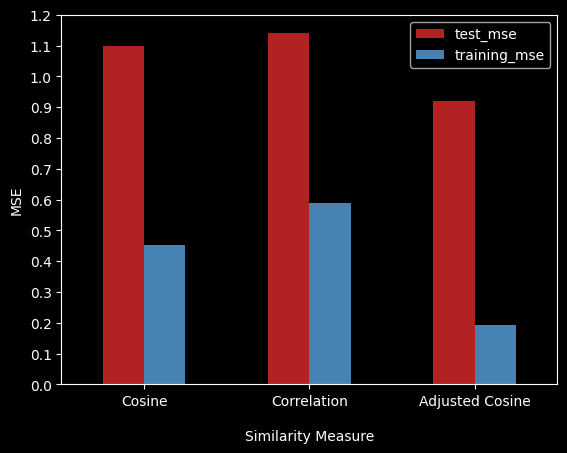

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

# train_mse_data = {"Cosine": cosine_train_mse, "Correlation": correlation_train_mse, 
#                   "Adjusted Cosine": adj_cosine_train_mse}
# test_mse_data = {"Cosine": cosine_test_mse, "Correlation": correlation_test_mse, 
#                  "Adjusted Cosine": adj_cosine_test_mse}
# train_mse_df = pd.DataFrame(train_mse_data.items(), columns=["similarity_measure", "mse_value"])
# test_mse_df = pd.DataFrame(test_mse_data.items(), columns=["similarity_measure", "mse_value"])

mse_data = {"test_mse" :{"Cosine": cosine_test_mse, "Correlation": correlation_test_mse, 
            "Adjusted Cosine": adj_cosine_test_mse},
            "training_mse": {"Cosine": cosine_train_mse, "Correlation": correlation_train_mse, 
            "Adjusted Cosine": adj_cosine_train_mse}}

mse_df = pd.DataFrame.from_dict(mse_data)
mse_df = mse_df.rename_axis("similarity_measure").reset_index()

ax = mse_df.plot(kind="bar", x="similarity_measure", color=["firebrick", "steelblue"])
plt.style.use("dark_background")
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xlabel("Similarity Measure", labelpad=15)
plt.ylabel("MSE")
plt.show()
# plt.savefig("mse_plot.png")

## Try (ignore this section)

In [ ]:
# without zero row and col since userId and movieId starts from 1
from scipy.sparse import csr_matrix
n_users = ratings.userId.max()
n_movies = ratings.movieId.max()
ratings_data = ratings.rating
user_data = ratings.userId
item_data = ratings.movieId
adj_matrix = csr_matrix((ratings_data, (user_data - 1, item_data - 1)), shape = (n_users, n_movies))
adj_matrix.shape

In [ ]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]

In [ ]:
# change ratings to binary because of sparse dataset
# 0 if rating <= 2.5, 1 if rating > 2.5
# ratings["rating"] = ratings["rating"].gt(2.5).astype("int")

In [ ]:
user_rating_count = ratings.groupby("userId").size()
user_rating_count[user_rating_count.lt(20)]

In [ ]:
len(ratings["userId"].unique())